# Classes infomation

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import h5py
from keras.preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from tqdm import tqdm

In [2]:
hf = h5py.File('../dataset/h5py/train(224, 224, 3)','r')

In [3]:
hf['val_labels']

<HDF5 dataset "val_labels": shape (4215, 10), type "<f4">

In [4]:
pd.options.display.max_rows = 4000

In [5]:
d_list = pd.read_csv('../dataset/driver_imgs_list.csv')

In [6]:
d_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [7]:
class_id = d_list['classname'].value_counts().index
print('class_id: ',list(class_id))
print('shape list: ',d_list.shape)

class_id:  ['c0', 'c3', 'c4', 'c6', 'c2', 'c5', 'c1', 'c9', 'c7', 'c8']
shape list:  (22424, 3)


# 오분류 제외

In [9]:
mis = '../dataset/오분류/'
mis_filenames = list()
mis_index = list()
for i in class_id:
    mis_filenames += os.listdir(os.path.join(mis,i))
for i in mis_filenames:
    mis_index.extend(list(d_list[d_list['img']==i].index))
d_list = d_list.drop(mis_index)

# 제외 후 리스트

In [10]:
d_list.shape

(21594, 3)

In [11]:
d_list.groupby(['subject','classname']).count()

img
subject classname     
p002    c0          75
        c1          74
        c2          86
        c3          79
        c4          84
        c5          76
        c6          83
        c7          72
        c8          40
        c9          43
p012    c0          84
        c1          89
        c2          91
        c3          89
        c4          96
        c5          96
        c6          75
        c7          72
        c8          59
        c9          45
p014    c0         100
        c1         103
        c2         100
        c3         100
        c4         103
        c5         102
        c6         101
        c7          75
        c8          25
        c9          35
p015    c0          78
        c1          85
        c2          88
        c3          89
        c4         100
        c5         101
        c6          99
        c7          81
        c8          69
        c9          52
p016    c0         110
        c1         102
        c2         101
        c3         127
        c4         104
        c5         104
        c6         108
        c7         101
        c8          91
        c9         116
p021    c0         135
        c1         131
        c2         127
        c3         128
        c4         132
        c5         130
        c6         126
        c7          98
        c8          90
        c9          98
p022    c0         129
        c1         129
        c2         128
        c3         129
        c4         130
        c5         130
        c6         131
        c7          98
        c8          97
        c9         108
p024    c0         130
        c1         129
        c2         128
        c3         130
        c4         129
        c5         131
        c6         129
        c7         101
        c8          99
        c9         103
p026    c0         130
        c1         129
        c2         130
        c3         131
        c4         125
        c5         130
        c6         128
        c7          97
        c8          96
        c9          55
p035    c0          93
        c1          80
        c2          88
        c3          88
        c4          89
        c5          89
        c6          94
        c7          87
        c8          56
        c9          61
p039    c0          65
        c1          63
        c2          70
        c3          65
        c4          62
        c5          64
        c6          63
        c7          64
        c8          68
        c9          46
p041    c0          59
        c1          64
        c2          60
        c3          60
        c4          60
        c5          61
        c6          61
        c7          61
        c8          59
        c9          51
p042    c0          59
        c1          59
        c2          60
        c3          59
        c4          58
        c5          59
        c6          59
        c7          59
        c8          59
        c9          52
p045    c0          75
        c1          75
        c2          76
        c3          74
        c4          75
        c5          75
        c6          71
        c7          67
        c8          66
        c9          62
p047    c0          80
        c1          91
        c2          81
        c3          86
        c4          81
        c5          87
        c6          81
        c7          81
        c8          82
        c9          66
p049    c0          84
        c1          85
        c2         119
        c3         110
        c4         109
        c5         116
        c6         119
        c7          74
        c8          79
        c9         116
p050    c0         122
        c1          45
        c2          52
        c3          97
        c4          83
        c5          91
        c6          82
        c7          80
        c8          61
        c9          40
p051    c0         172
        c1          81
        c2       

In [12]:
p_cnt = d_list['subject'].value_counts()
p_val = p_cnt[-7:]
print('Number of people: ',np.sum(p_cnt))
print('Number of validation set(rate:0.2): ',int(np.sum(p_cnt) * 0.2))
print('Validation ID: ',list(p_val.index))
print('Validation set: ',np.sum(p_val))

Number of people:  21594
Number of validation set(rate:0.2):  4318
Validation ID:  ['p052', 'p081', 'p064', 'p039', 'p041', 'p042', 'p072']
Validation set:  4215


In [13]:
val_list = pd.DataFrame([],columns=d_list.columns)
for i in p_val.index:
    val_list = pd.concat([val_list,d_list[d_list['subject']==i]], axis=0)
train_list = pd.DataFrame([],columns=d_list.columns)
for i in p_cnt[:-7].index:
    train_list = pd.concat([train_list,d_list[d_list['subject']==i]], axis=0)

# Functions

In [16]:
def cnt_image(image_list):
    classes_cnt = image_list['classname'].value_counts()
    ordered_idx = sorted(classes_cnt.index)
    c_cnt = classes_cnt[ordered_idx]
    c_per = round(classes_cnt[ordered_idx] / sum(classes_cnt) * 100, 1)
    classes_info = pd.DataFrame({'count': c_cnt, 'percent': c_per}, index=c_cnt.index)
    print(classes_info)

In [17]:
def aug_image(name, image_list, fold):
    image_dir = '../dataset/train/'
    
    c_list = os.listdir(image_dir)
    cnt = image_list['classname'].value_counts()
    
    imgs = list()
    labels = list()
    for i in range(1):
        c_dir = os.path.join(image_dir,cnt.index[i])
        labels.extend(to_categorical([i]*cnt[i], 10))
        imgs_dir = list(image_list[image_list['classname']==cnt.index[i]]['img'])
        for j in tqdm(range(len(imgs_dir))):
            im = load_img(c_dir + '/' + imgs_dir[j], target_size=(224,224))
            arr = img_to_array(im)
            imgs.append(arr)
    
    i = 0
    aug_imgs = list()
    aug_labels = list()
    for x, y in tqdm(data_generator(np.array(imgs), labels, batch_size=np.sum(cnt), seed=1223, shuffle=True)):
        aug_imgs.extend(x)
        aug_labels.extend(y)
        i += 1
        if i == fold:
            break
    return aug_imgs, aug_labels

In [549]:
def data_generator(images, labels, batch_size, seed=None, shuffle=True):
    datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range=15,
                zoom_range=[0.8,0.8]
                )
    iterator = datagen.flow(
        x = images,
        y = labels,
        batch_size = batch_size,
        seed=seed,
        shuffle=shuffle
    )
    for batch_x, batch_y in iterator:
        batch_x = random_crop(batch_x)
        yield batch_x, batch_y

In [944]:
def random_crop(imgs):
    crop_imgs = np.array([],dtype='float32').reshape(0,224,224,3)
    for arr in imgs:
        raw_size = arr.shape[0]
        c = raw_size - 312
        crop_size = raw_size - c
        
        x = np.random.choice([0,50,100,150,200])
        y = np.random.choice([0,50,100,150,200])
        arr =  arr[y:(crop_size+y), x:(crop_size+x), :]

        im = array_to_img(arr)
        im = im.resize((224,224))
        arr = img_to_array(im).reshape(1,224,224,3)
        
        crop_imgs = np.vstack([crop_imgs,arr])
    return crop_imgs
        

# Augmentation test

In [945]:
imgs_dir = list(train_list[train_list['classname']=='c8']['img'])
image_dir = '../dataset/train/'
c_dir = os.path.join(image_dir,'c8')
im = load_img(c_dir + '/' + imgs_dir[242], target_size=(512,512))
arr = img_to_array(im).reshape(1,512,512,3)
labels = to_categorical([0], 10)

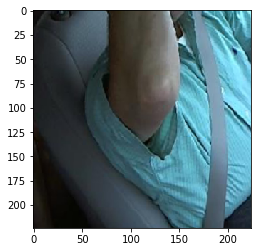

In [982]:
for x, y in data_generator(arr, labels, batch_size=1, seed=None, shuffle=True):
    plt.imshow(array_to_img(x.reshape(224,224,3)))
    break

# Number of Class by data

In [164]:
print(cnt_image(train_list))
print('=' * 100)
print(cnt_image(val_list))

    count  percent
c0   2019     11.2
c1   1799     10.0
c2   1845     10.2
c3   1902     10.5
c4   1881     10.4
c5   1898     10.5
c6   1876     10.4
c7   1606      8.9
c8   1521      8.4
c9   1695      9.4
None
    count  percent
c0    470     10.7
c1    468     10.7
c2    472     10.8
c3    444     10.1
c4    445     10.2
c5    414      9.4
c6    449     10.2
c7    396      9.0
c8    390      8.9
c9    434      9.9
None


## Test images

In [33]:
test_dir = '../dataset/test/'
test_h5py = '../dataset/h5py/test(224, 224, 3)'

In [34]:
test_list = os.listdir(test_dir)
print(len(test_list))

79726


In [35]:
rate = len(test_list) // 10

In [36]:
test_imgs = os.listdir(test_dir) 
test_imgs1 = test_imgs[:rate*1]
test_imgs2 = test_imgs[rate*1:rate*2]
test_imgs3 = test_imgs[rate*2:rate*3]
test_imgs4 = test_imgs[rate*3:rate*4]
test_imgs5 = test_imgs[rate*4:rate*5]
test_imgs6 = test_imgs[rate*5:rate*6]
test_imgs7 = test_imgs[rate*6:rate*7]
test_imgs8 = test_imgs[rate*7:rate*8]
test_imgs9 = test_imgs[rate*8:rate*9]
test_imgs10 = test_imgs[rate*9:]
test_imgs_list = [test_imgs1, test_imgs2, test_imgs3, test_imgs4, test_imgs5, test_imgs6, test_imgs7, test_imgs8, test_imgs9, test_imgs10]

In [37]:
hf = h5py.File(test_h5py,'w')
for i in range(len(test_imgs_list)):
    test_imgs_i = np.zeros((len(test_imgs_list[i]),224,224,3))
    for j in tqdm(range(len(test_imgs_list[i]))):
        im = load_img(test_dir + test_imgs_list[i][j], target_size=(224,224), color_mode='grayscale')
        arr = img_to_array(im)
        test_imgs_i[j] = arr
    hf.create_dataset('test' + str(i), data=test_imgs_i, compression='lzf')
hf.close()






  0%|                                                                                         | 0/7972 [00:00<?, ?it/s]




  0%|                                                                               | 12/7972 [00:00<01:10, 113.51it/s]




  0%|▏                                                                              | 25/7972 [00:00<01:06, 119.37it/s]




  0%|▎                                                                              | 35/7972 [00:00<01:10, 112.12it/s]




  1%|▍                                                                              | 48/7972 [00:00<01:08, 115.97it/s]




  1%|▌                                                                              | 61/7972 [00:00<01:06, 118.08it/s]




  1%|▋                                                                              | 74/7972 [00:00<01:06, 119.10it/s]




  1%|▊                                                                              | 86/7972 [00:00<01:06, 118.27it/s]




  1

KeyboardInterrupt: 